In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import os
import time
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from collections import namedtuple
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from data.othello import Othello, OthelloBoardState, permit, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.model import GPT, GPTConfig, GPTforProbing, GPTforProbeIA
from mingpt.probe_trainer import Trainer, TrainerConfig
from mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer

## Evaluating linear board probes

### accuracy of single probe

In [4]:
layer = 6
model_ckpt = "bias/TLcontrol"

In [5]:
othello = Othello(data_root="othello_synthetic", n_games=10000, deduplicate=False, test_split=0)

# player_types, games = zip(*othello)
train_dataset = CharDataset(othello)

mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbing(mconf, probe_layer=layer)
load_res = model.load_state_dict(torch.load(f"./ckpts/{model_ckpt}.ckpt"))


if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)

Mem Used: 1.124 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 10000 for training, 0 for validation
Dataset created has 10000 sequences, 61 unique words.


In [6]:
# creating dataset of activations and properties
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
act_container = []
property_container = []

for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
    # truncates game if it is less than 60 moves
    valid_until = tbf.index(-100) if -100 in tbf else 999

    properties = []
    ob = OthelloBoardState()
    for i, move in enumerate(tbf[:valid_until]):
        ob.update([move])

        # flipping states so always from moving player's perspective
        fixed_state = np.array(ob.get_state())
        if ob.get_next_hand_color() == 1:
            fixed_state = 2 - fixed_state
        properties.append(fixed_state)
    property_container.extend(properties)

    # gets activations for each move
    act = model(x.to(device))[0, ...].detach().cpu()  # [block_size, f]
    act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
    act_container.extend(act)

    assert len(act_container) == len(property_container)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-6-9a1f5b2ebd71>:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
<ipython-input-6-9a1f5b2ebd71>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
100%|██████████| 10000/10000 [01:

In [7]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"{len(act)} pairs loaded...")
        self.act = act
        self.y = y
        # print(np.sum(np.array(y)==0), np.sum(np.array(y)==1), np.sum(np.array(y)==2))
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    def __getitem__(self, idx):
        return self.act[idx], torch.tensor(self.y[idx]).to(torch.long)

probing_dataset = ProbingDataset(act_container, property_container)

probe_loader = DataLoader(probing_dataset, shuffle=False, pin_memory=True, batch_size=128, num_workers=1)

589847 pairs loaded...
y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


In [8]:
probe = BatteryProbeClassification(device, probe_class=3, num_task=64)
load_res = probe.load_state_dict(torch.load(f"./ckpts/bias/probes/state_control/layer{layer}/checkpoint.ckpt"))

probe = probe.to(device)

In [9]:
total_games = 0
total_correct = np.zeros(64)

pbar = tqdm(probe_loader, total=len(probe_loader))
for x, y in pbar:
    x = x.to(device)  # [B, f]
    y = y.to(device)  # [B, #task=64] 

    logits, loss = probe(x, y)
    pred = torch.argmax(logits, dim=2)

    correct = torch.sum(pred == y, dim=0)
    correct = correct.detach().cpu().numpy()
    np.add(total_correct, correct, out=total_correct)

    total_games += x.shape[0]

    pbar.set_description(f"{sum(total_correct) / (total_games * 64):.5f}% correct")

print(total_games)
print(total_correct)

  0%|          | 0/4609 [00:00<?, ?it/s]

0.97951% correct: 100%|██████████| 4609/4609 [00:11<00:00, 392.31it/s]

589847
[576371. 582143. 581946. 582739. 581937. 582377. 582177. 582412. 581503.
 580546. 577970. 576918. 576786. 578917. 581434. 582210. 580729. 578120.
 573501. 569958. 570065. 574714. 579118. 581773. 582683. 577304. 570612.
 564032. 565104. 570389. 577189. 583142. 582634. 577286. 570551. 565025.
 564615. 569964. 577301. 583002. 582970. 578653. 574812. 570665. 570686.
 574330. 578696. 582357. 579852. 580844. 579217. 577245. 577210. 579020.
 580757. 578786. 582935. 579399. 580850. 582543. 582705. 582132. 582042.
 580778.]


Text(0.5, 1.0, 'Layer 6 Probe Accuracy')

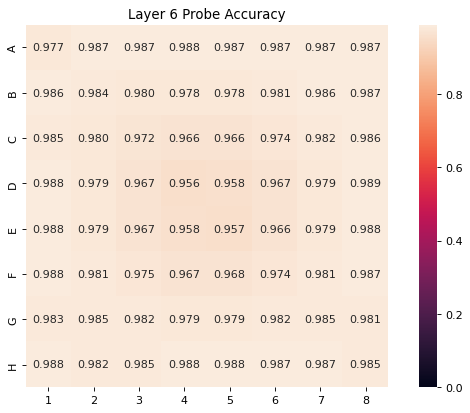

In [11]:
avg = total_correct / total_games
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(avg.reshape(8, 8), vmin=0,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".3f")

plt.title("Layer 6 Probe Accuracy")

### accuracy for all layers at once

In [4]:
all_layers = range(1, 9)

In [5]:
othello = Othello(data_root="othello_synthetic", n_games=10000, deduplicate=False, test_split=0, quiet=True)
train_dataset = CharDataset(othello)

Dataset created has 10000 sequences, 61 unique words.


In [6]:
model_ckpt = "bias/TLcontrol"

mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbeIA(mconf, probe_layer=0)
load_res = model.load_state_dict(torch.load(f"./ckpts/{model_ckpt}.ckpt"))

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)

In [7]:
# creating dataset of activations and properties
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
act_container = []
property_container = []

layer_act_container = {i: [] for i in all_layers}

for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
    # truncates game if it is less than 60 moves
    valid_until = tbf.index(-100) if -100 in tbf else 999

    # store board state, flipped to model perspective
    properties = []
    ob = OthelloBoardState()
    for i, move in enumerate(tbf[:valid_until]):
        ob.update([move])

        # flipping states so always from moving player's perspective
        fixed_state = np.array(ob.get_state())
        if ob.get_next_hand_color() == 1:
            fixed_state = 2 - fixed_state
        properties.append(fixed_state)
    property_container.extend(properties)

    # gets activations for each move
    x = model.forward_1st_stage(x.to(device))
    cached = model.forward_2nd_stage(x, 0)

    for i, act in enumerate(cached):
        act = act[0, ...].detach().cpu()
        act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])

        layer_act_container[i+1].extend(act)
        assert len(layer_act_container[i+1]) == len(property_container)


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-7-3f4ba481399f>:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
<ipython-input-7-3f4ba481399f>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
100%|██████████| 10000/10000 [02:

In [8]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"{len(act)} pairs loaded...")
        self.act = act
        self.y = y
        # print(np.sum(np.array(y)==0), np.sum(np.array(y)==1), np.sum(np.array(y)==2))
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    def __getitem__(self, idx):
        return self.act[idx], torch.tensor(self.y[idx]).to(torch.long)

In [9]:
def calc_probe_accuracy_by_board_square(probe, device, probing_dataset):
    probe = probe.to(device)

    probe_loader = DataLoader(probing_dataset, shuffle=False, pin_memory=True, batch_size=128, num_workers=1)

    total_games = 0
    total_correct = np.zeros(64)

    pbar = tqdm(probe_loader, total=len(probe_loader))
    for x, y in pbar:
        x = x.to(device)  # [B, f]
        y = y.to(device)  # [B, #task=64] 

        logits, loss = probe(x, y)
        pred = torch.argmax(logits, dim=2)

        correct = torch.sum(pred == y, dim=0)
        correct = correct.detach().cpu().numpy()
        np.add(total_correct, correct, out=total_correct)

        total_games += x.shape[0]

        pbar.set_description(f"{sum(total_correct) / (total_games * 64):.5f}% correct")

    return total_games, total_correct


In [10]:
probe_acc = {}

for layer in all_layers:
    acts = layer_act_container[layer]
    probing_dataset = ProbingDataset(acts, property_container)

    probe = BatteryProbeClassification(device, probe_class=3, num_task=64)
    load_res = probe.load_state_dict(torch.load(f"./ckpts/bias/probes/state_control/layer{layer}/checkpoint.ckpt"))
    # load_res = probe.load_state_dict(torch.load(f"./ckpts/bias/probes/state_control/layer6/checkpoint.ckpt"))

    total_games, total_correct = calc_probe_accuracy_by_board_square(probe, device, probing_dataset)
    probe_acc[layer] = total_correct / total_games

589847 pairs loaded...


  0%|          | 0/4609 [00:00<?, ?it/s]

y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


0.87506% correct: 100%|██████████| 4609/4609 [00:14<00:00, 322.36it/s]


589847 pairs loaded...


  0%|          | 0/4609 [00:00<?, ?it/s]

y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


0.92301% correct: 100%|██████████| 4609/4609 [00:13<00:00, 350.75it/s]


589847 pairs loaded...


  0%|          | 0/4609 [00:00<?, ?it/s]

y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


0.95149% correct: 100%|██████████| 4609/4609 [00:13<00:00, 329.62it/s]


589847 pairs loaded...


  0%|          | 0/4609 [00:00<?, ?it/s]

y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


0.96569% correct: 100%|██████████| 4609/4609 [00:13<00:00, 343.30it/s]


589847 pairs loaded...


  0%|          | 0/4609 [00:00<?, ?it/s]

y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


0.97524% correct: 100%|██████████| 4609/4609 [00:14<00:00, 323.24it/s]


589847 pairs loaded...


  0%|          | 0/4609 [00:00<?, ?it/s]

y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


0.97934% correct: 100%|██████████| 4609/4609 [00:14<00:00, 327.79it/s]


589847 pairs loaded...


  0%|          | 0/4609 [00:00<?, ?it/s]

y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


0.97729% correct: 100%|██████████| 4609/4609 [00:13<00:00, 344.45it/s]


589847 pairs loaded...


  0%|          | 0/4609 [00:00<?, ?it/s]

y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


0.97554% correct: 100%|██████████| 4609/4609 [00:14<00:00, 325.62it/s]


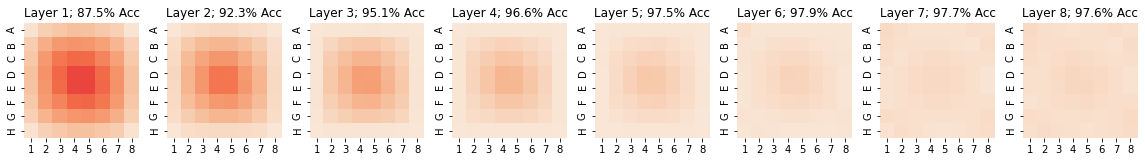

In [27]:
fig, axs = plt.subplots(1, 8, figsize=(16, 3))

for i, layer in enumerate(all_layers):
    ax: plt.Axes = axs[i]
    sns.heatmap(probe_acc[layer].reshape(8, 8), ax=ax,
                vmin=0.3, vmax=1, square=True,
                yticklabels=list("ABCDEFGH"), xticklabels=list(range(1, 9)),
                cbar=False)
    ax.set_title(f"Layer {layer}; {np.average(probe_acc[layer]) * 100:.1f}% Acc")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Common Per Turn Baseline')

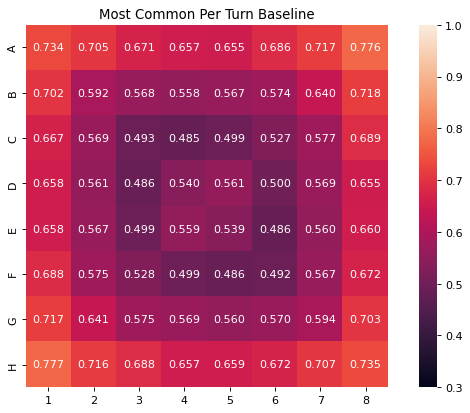

In [29]:
baseline = np.load("visuals/data/probe_baseline_time_10k.npy")
to_plot = baseline
# to_plot = probe_acc[6]

fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(to_plot.reshape(8, 8), vmin=0.3, vmax=1,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".3f")

plt.title("Most Common Per Turn Baseline")

### cosine similarity

In [4]:
all_layers = range(1, 9)
probes = {}
for layer in all_layers:
    p = BatteryProbeClassification(torch.cuda.current_device(), probe_class=3, num_task=64)
    load_res = p.load_state_dict(torch.load(f"./ckpts/bias/probes/state_control/layer{layer}/checkpoint.ckpt"))
    p.eval()
    probes[layer] = p

In [5]:
# m = probes[6].proj.weight.data.reshape((64, 3, -1))  # [64, 3, 512]
m = {i: probes[i].proj.weight.data.reshape((64, 3, -1)) for i in all_layers}

torch.Size([64, 512])
(64, 64)


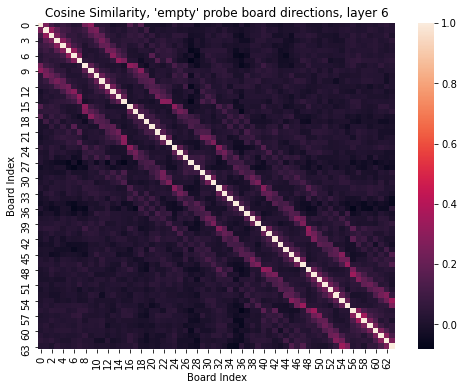

In [6]:
tensors = m[6][:, 2, :]
print(tensors.shape)
grid = np.zeros((tensors.shape[0], tensors.shape[0]))
print(grid.shape)
for i, t1 in enumerate(tensors):
    for j, t2 in enumerate(tensors):
        cos = torch.nn.functional.cosine_similarity(t1, t2, dim=0)
        grid[(i, j)] = cos

plt.figure(figsize=(8, 6))
sns.heatmap(grid, vmax=1)
plt.xlabel("Board Index")
plt.ylabel("Board Index")
plt.title("Cosine Similarity, 'empty' probe board directions, layer 6")
plt.show()

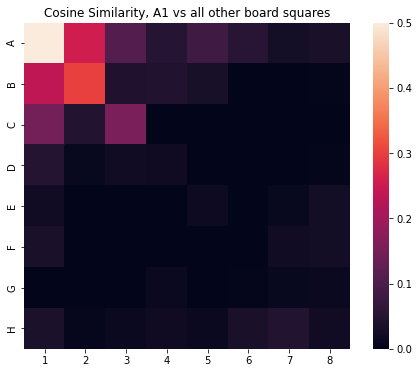

In [9]:
grid = np.zeros(64)
board_state = 2
for i in range(len(grid)):
    t1 = m[6][permit("a1"), board_state, :]
    t2 = m[6][i, board_state, :]
    cos = torch.nn.functional.cosine_similarity(t1, t2, dim=0)
    grid[i] = cos

plt.figure(figsize=(8, 6))
sns.heatmap(grid.reshape((8, 8)), vmax=0.5, vmin=0, yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True,)
plt.title("Cosine Similarity, A1 vs all other board squares")
plt.show()

## Linear board interventions

### utils

In [4]:
def draw_board_heatmap(board, **kwargs):
    fig = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8), **kwargs,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".3f")
    return fig

In [5]:
def draw_heatmap_from_tokens(token_pred, **kwargs):
    # take off first token, as it isn't a board position
    token_pred = token_pred[1:]
    # add padding to get from tokens -> board positions
    padding = np.zeros(2)
    board = np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)
    # plotting
    return draw_board_heatmap(board, **kwargs)

In [6]:
def load_linear_probes(ckpt_path, layer_range, probe_class=3, num_task=64):
    probes = {}
    for layer in layer_range:
        p = BatteryProbeClassification(torch.cuda.current_device(), probe_class=probe_class, num_task=num_task)
        load_res = p.load_state_dict(torch.load(f"./ckpts/{ckpt_path}/layer{layer}/checkpoint.ckpt"))
        p.eval()
        probes[layer] = p
    return probes

In [7]:
def load_model_layers(ckpt_path, layer_range):
    mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)

    models = {}
    for layer in layer_range:
        model = GPTforProbeIA(mconf, probe_layer=layer)
        # model = GPT(mconf)
        load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt_path}.ckpt"))
        if torch.cuda.is_available():
            device = torch.cuda.current_device()
            model = model.to(device)
        _ = model.eval()
        models[layer] = model

    return models, device

In [8]:
def get_probe_logits(models, device, probes, layer, completion, softmax=False):
    p = probes[layer]
    
    partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)
    whole_mid_act = models[layer].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
    mid_act = whole_mid_act[0, -1]
    logits = p(mid_act[None, :])[0].squeeze(0)  # [num_task, probe_class]

    if softmax:
        logits = torch.softmax(logits, dim=-1)

    return logits.detach().cpu().numpy()

In [9]:
def get_probe_board_state(probe, act):
    logits = probe(act[None, :])[0].squeeze(0)  # [64, 3]
    labels = logits.detach().argmax(dim=-1)
    # print(labels)

    ob = OthelloBoardState()
    ob.state = labels.reshape((8, 8)) - 1
    return ob

In [10]:
def intervene(models, device, probes, completion, i_layers, desired_probe_state=None, scale=1):
    all_layers = range(1, 9)

    partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)
    pre_intv_pred, _ = models[all_layers.stop-1](partial_game[None, :])  # [B, T, F=512]
    pre_intv_pred = pre_intv_pred[0, -1, :].detach().cpu().numpy()

    # tracking probes across the intervention
    saved_probe_logits = []

    for i, current_layer in enumerate(all_layers):
        p = probes[current_layer]

        if i == 0:
            whole_mid_act = models[all_layers.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
        # after starting layer, use forward_2nd_stage to get to next layer
        else:
            whole_mid_act = models[all_layers.start].forward_2nd_stage(whole_mid_act, current_layer-1, current_layer)[0]  # [1, T, F=512]

        # cut out most recent features and check probe prediction
        mid_act = whole_mid_act[0, -1]
        pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
        saved_probe_logits.append(pre_intv_logits)

        if current_layer not in i_layers:
            continue

        # make actual intervention on mid activations
        new_mid_act = mid_act.clone()

        # linear intervention (simple steering vector)
        # m = p.proj.weight.data.reshape((64, 3, -1))  # [64, 3, 512]
        # for bi in intvs:
        #     new_mid_act += m[permit(bi.pos), bi.end] * scale
        #     new_mid_act -= m[permit(bi.pos), bi.start] * scale

        # linear intervention (adding proj inverse of goal state)
        pinv = torch.pinverse(p.proj.weight.data)  # [512, 192]
        desired_probe_tensor = torch.from_numpy(desired_probe_state).to(pinv.dtype).to(device)
        new_mid_act = torch.matmul(pinv, desired_probe_tensor.reshape(192))

        # swap in 
        whole_mid_act[0, -1] = new_mid_act

    post_intv_pred, _ = models[all_layers.start].predict(whole_mid_act)
    post_intv_pred = post_intv_pred[0, -1, :].detach().cpu().numpy()

    saved_probe_logits = np.array([x.detach().cpu().numpy() for x in saved_probe_logits])
    return pre_intv_pred, post_intv_pred, saved_probe_logits

### matrix board state intervention

In [24]:
all_layers = range(1, 9)
models, device = load_model_layers("bias/TLcontrol", all_layers)
probes = load_linear_probes("bias/probes/state_control", all_layers)

In [25]:
othello = Othello(data_root="othello_synthetic", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.807 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


In [26]:
game_index = 3
completion = othello[game_index][:11]

pre_board = OthelloBoardState()
pre_board.update(completion)
print("next color:", pre_board.get_next_hand_color())
pre_board.__print__()
print([permit_reverse(x) for x in pre_board.get_valid_moves()])

next color: 0
--------------------
['f5', 'd6', 'c6', 'f4', 'e6', 'c7', 'd7', 'f6', 'e3', 'e7', 'g3']
a                
b                
c           X O  
d       O X X O  
e     X X X X O  
f       X O O    
g     X          
h                
  1 2 3 4 5 6 7 8
--------------------
['b5', 'b6', 'c5', 'd3', 'e2', 'f2', 'f3', 'g4', 'h2']


In [27]:
partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)

pre_intv_pred, _ = models[all_layers.stop-1](partial_game[None, :])  # [B, T, F=512]
pre_intv_pred = pre_intv_pred[0, -1, :].detach().cpu().numpy()

In [28]:
def get_post_intv_board(completion, intvs):
    post_intv_ob = OthelloBoardState()
    post_intv_ob.update(completion)
    for bi in intvs:
        pos = permit(bi.pos)
        r, c = pos // 8, pos % 8
        # this only works if turn is correct, FIX LATER
        post_intv_ob.state[r, c] = bi.end - 1
    return post_intv_ob

In [29]:
def get_probe_goal_state(ob):
    goal_state = [
        [5, -10, -2], # my color
        [-5, 10, -5], # empty
        [-2, -10, 5], # opp color
    ]
    desired_probe_state = np.zeros((64, 3))

    state = np.array(ob.get_state())
    desired_probe_state[state == 0] = goal_state[0]
    desired_probe_state[state == 1] = goal_state[1]
    desired_probe_state[state == 2] = goal_state[2]

    # desired_probe_state[state == 1] = goal_state[1]
    # if ob.get_next_hand_color():
    #     desired_probe_state[state == 2] = goal_state[0]
    #     desired_probe_state[state == 0] = goal_state[2]
    # else:
    #     desired_probe_state[state == 0] = goal_state[0]
    #     desired_probe_state[state == 2] = goal_state[2]
    
    return desired_probe_state

In [30]:
logits = get_probe_logits(models, device, probes, 5, completion)
state = np.array(pre_board.get_state())
for i, s in enumerate(["my color", "empty", "opp color"]):
    print(s)
    print(np.average(logits[state == i], axis=0))
    print(np.std(logits[state == i], axis=0))

my color
[ 5.815207  -9.183225  -1.4971552]
[0.8174066 0.725552  0.8407279]
empty
[-5.158872  8.386607 -5.555351]
[1.8336788 1.7675492 1.069229 ]
opp color
[-1.4239931 -8.765981   5.2779446]
[0.8756225 0.9993332 0.8529787]


In [31]:
BoardIntervention = namedtuple("BoardIntervention", ["pos", "start", "end"])
intvs = [
    BoardIntervention("b6", 1, 2),
    BoardIntervention("b5", 1, 0),
    BoardIntervention("b7", 1, 2),
    # BoardIntervention("f3", 1, 0),
]

transfer_completion = othello[1][:11]

post_intv_board = get_post_intv_board(completion, intvs)
# post_intv_board = get_post_intv_board(transfer_completion, [])
# post_intv_board = other_ob
desired_probe_state = get_probe_goal_state(post_intv_board)
post_intv_board.__print__()

--------------------
['f5', 'd6', 'c6', 'f4', 'e6', 'c7', 'd7', 'f6', 'e3', 'e7', 'g3']
a                
b         O X X  
c           X O  
d       O X X O  
e     X X X X O  
f       X O O    
g     X          
h                
  1 2 3 4 5 6 7 8
--------------------


In [32]:
scale = 2
intervene_layers = [4]

board_probe_logits = []

for i, layer in enumerate(all_layers):
    p = probes[layer]

    # at starting layer, we set up the intervention by doing a forward pass up to the starting layer
    if i == 0:
        print("setting up intervention starting at layer", layer)
        whole_mid_act = models[all_layers.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
    # after starting layer, use forward_2nd_stage to get to next layer
    else:
        whole_mid_act = models[all_layers.start].forward_2nd_stage(whole_mid_act, layer-1, layer)[0]  # [1, T, F=512]


    print("LAYER", layer)

    # cut out most recent features and check probe prediction
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    for bi in intvs:
        print(f"{bi.pos} logits: {pre_intv_logits[permit(bi.pos)]}")

    board_probe_logits.append(pre_intv_logits)

    print("pre intv board:")
    probe_board = get_probe_board_state(p, mid_act)
    probe_board.__print__()

    if layer not in intervene_layers:
        continue

    # make actual intervention on mid activations
    new_mid_act = mid_act.clone()

    # linear intervention (simple steering vector)
    m = p.proj.weight.data.reshape((64, 3, -1))  # [64, 3, 512]
    for bi in intvs:
        new_mid_act += m[permit(bi.pos), bi.end] * scale
        # new_mid_act -= m[permit(bi.pos), bi.start] * scale

    # linear intervention (adding proj inverse of goal state)
    # pinv = torch.pinverse(p.proj.weight.data)  # [512, 192]
    # desired_probe_tensor = torch.from_numpy(desired_probe_state).to(pinv.dtype).to(device)
    # replacement_act = torch.matmul(pinv, desired_probe_tensor.reshape(192))

    # new_mid_act = torch.lerp(new_mid_act, replacement_act, 0.8)


    post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
    labels_post_intv = post_intv_logits.detach().argmax(dim=-1)
    for bi in intvs:
        print(f"{bi.pos} logits: {post_intv_logits[permit(bi.pos)]}")

    board_probe_logits.append(post_intv_logits)

    print("post intv board:")
    probe_board = get_probe_board_state(p, new_mid_act)
    probe_board.__print__()

    # swap in 
    whole_mid_act[0, -1] = new_mid_act

tb_resumed = whole_mid_act
post_intv_pred, _ = models[all_layers.start].predict(tb_resumed)
post_intv_pred = post_intv_pred[0, -1, :].detach().cpu().numpy()

setting up intervention starting at layer 1
LAYER 1
b6 logits: tensor([-5.3950,  6.9417, -4.7229], device='cuda:0', grad_fn=<SelectBackward>)
b5 logits: tensor([-4.8095,  6.3846, -4.2594], device='cuda:0', grad_fn=<SelectBackward>)
b7 logits: tensor([-3.9549,  6.2604, -4.3363], device='cuda:0', grad_fn=<SelectBackward>)
pre intv board:
--------------------
[]
a                
b                
c           X O  
d       X X O O  
e     X X X O O  
f       X O O    
g     X          
h                
  1 2 3 4 5 6 7 8
--------------------
LAYER 2
b6 logits: tensor([-4.6733,  8.3169, -4.8507], device='cuda:0', grad_fn=<SelectBackward>)
b5 logits: tensor([-5.0751,  6.3096, -4.1407], device='cuda:0', grad_fn=<SelectBackward>)
b7 logits: tensor([-2.6405,  7.3893, -5.4048], device='cuda:0', grad_fn=<SelectBackward>)
pre intv board:
--------------------
[]
a                
b                
c           X O  
d       O X X O  
e     X X X O O  
f       X O O    
g     X          
h          

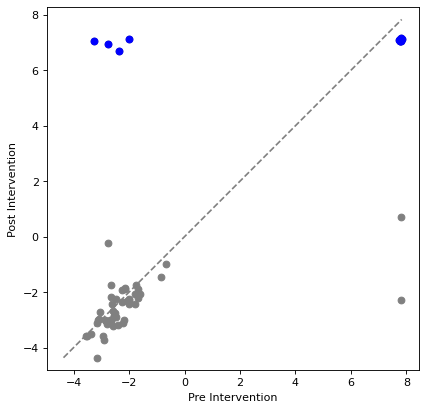

In [33]:
fig, ax = plt.subplots(1, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

x, y = pre_intv_pred[1:], post_intv_pred[1:]

# plotting illegal moves in grey
ax.scatter(x, y, color='grey', zorder=1)
# plotting legal moves as blue
# valid_tokens = [train_dataset.stoi[x] - 1 for x in get_post_intv_board(completion, intvs).get_valid_moves()]
valid_tokens = [train_dataset.stoi[x] - 1 for x in post_intv_board.get_valid_moves()]
ax.scatter(x[valid_tokens], y[valid_tokens], color='blue', zorder=2)

# plotting x=y for context
axis_min = min(min(x), min(y))
axis_max = max(max(x), max(y))
ax.plot([axis_min, axis_max], [axis_min, axis_max], color='grey', linestyle='dashed', zorder=0)

# axis, labels
ax.set_xlabel("Pre Intervention")
ax.set_ylabel("Post Intervention")
ax.axis('equal')

plt.show()

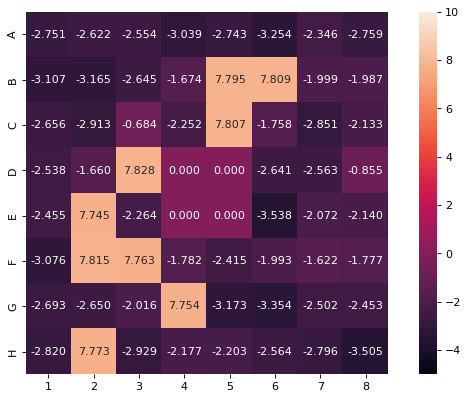

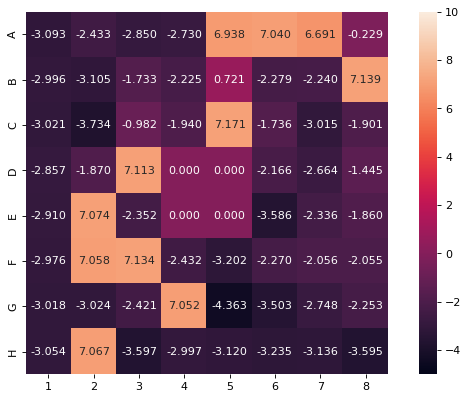

In [34]:
fig = draw_heatmap_from_tokens(pre_intv_pred, vmin=-5, vmax=10)
fig = draw_heatmap_from_tokens(post_intv_pred, vmin=-5, vmax=10)

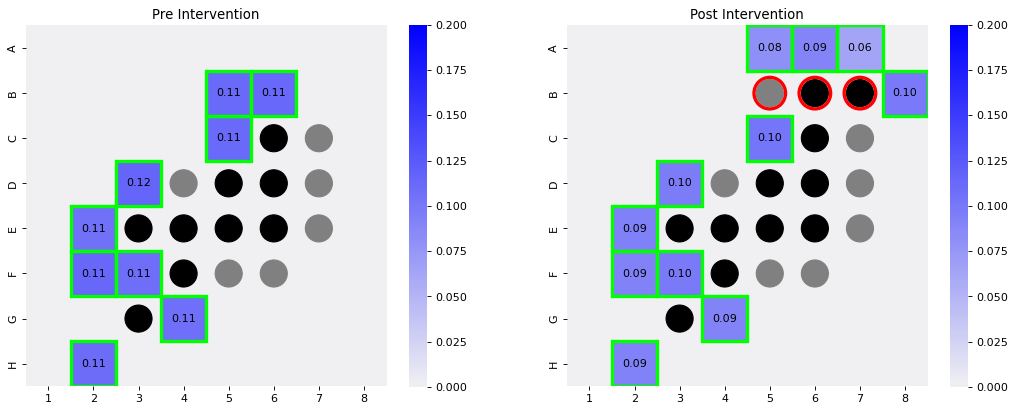

In [35]:
def draw_board_state_with_pred(ax: plt.Axes, ob, pred, intvs=[]):
    sns.heatmap(pred.reshape(8, 8), ax=ax,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), 
            # cmap=sns.color_palette("flare", as_cmap=True),
            cmap=sns.light_palette("blue", as_cmap=True),
            vmax=0.2, vmin=0,
            square=True)

    # drawing white/black disks
    for loc, pos_state in enumerate(ob.get_state()):
        r, c = loc // 8, loc % 8
        if pos_state == 1:
            continue

        circle_color = "black" if pos_state else "gray"
        circle = plt.Circle((c + 0.5, r + 0.5), 0.3, color=circle_color, fill=True)
        ax.add_artist(circle)

    # highlighting valid moves
    valid = ob.get_valid_moves()
    for loc in valid:
        r, c = loc // 8, loc % 8
        rectangle = plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='lime', linewidth=3)
        ax.add_artist(rectangle)

    # drawing text for non-zero probabilities
    for loc, value in enumerate(pred):
        if value < 0.005 and loc not in valid:
            continue
        r, c = loc // 8, loc % 8
        ax.text(c + 0.5, r + 0.5, f"{value:.2f}", color='black', ha='center', va='center')

    # highlighting interventions
    for bi in intvs:
        loc = permit(bi.pos)
        r, c = loc // 8, loc % 8
        circle = plt.Circle((c + 0.5, r + 0.5), 0.35, fill=False, edgecolor='red', linewidth=3)
        ax.add_artist(circle)

from scipy.special import softmax
def format_pred(pred):
    token_pred = softmax(pred)[1:]
    padding = np.zeros(2)
    return np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=80)
draw_board_state_with_pred(axs[0], pre_board, format_pred(pre_intv_pred))
draw_board_state_with_pred(axs[1], post_intv_board, format_pred(post_intv_pred), intvs=intvs)

axs[0].set_title("Pre Intervention")
axs[1].set_title("Post Intervention")

plt.show()

In [36]:
import pandas as pd

def prediction_swarm_plot(ax, ob, pred):
    pred = pred[1:]

    valid_tokens = [train_dataset.stoi[x] - 1 for x in ob.get_valid_moves()]
    invalid_tokens = list(set(range(60)) - set(valid_tokens))

    legal_pred = pred[valid_tokens]
    illegal_pred = pred[invalid_tokens]

    combined_pred = np.concatenate([legal_pred, illegal_pred])
    swarm_df = pd.DataFrame({"Log Prob": combined_pred,
                         "Type": ["Legal"] * len(legal_pred) + ["Illegal"] * len(illegal_pred),
                         "Prediction": [""] * len(combined_pred)})
    
    sns.swarmplot(ax=ax, data=swarm_df, x="Prediction", y="Log Prob", hue="Type", palette={"Legal": "blue", "Illegal": "gray"})

<bound method Artist.set of <AxesSubplot:xlabel='Prediction', ylabel='Log Prob'>>

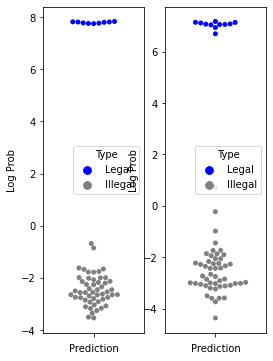

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(4, 6))

prediction_swarm_plot(axs[0], pre_board, pre_intv_pred)
prediction_swarm_plot(axs[1], post_intv_board, post_intv_pred)

axs[0].set

In [38]:
print([x.shape for x in board_probe_logits])
data = [x.softmax(dim=-1).detach().cpu().numpy() for x in board_probe_logits]
# data = [x[:, [1, 0, 2]] for x in data] # rearranging so order is empty, my color, opp color
print([x.shape for x in data])

[torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3])]
[(64, 3), (64, 3), (64, 3), (64, 3), (64, 3), (64, 3), (64, 3), (64, 3), (64, 3)]


['1', '2', '3', '4 (pre)', '4 (post)', '5', '6', '7', '8']


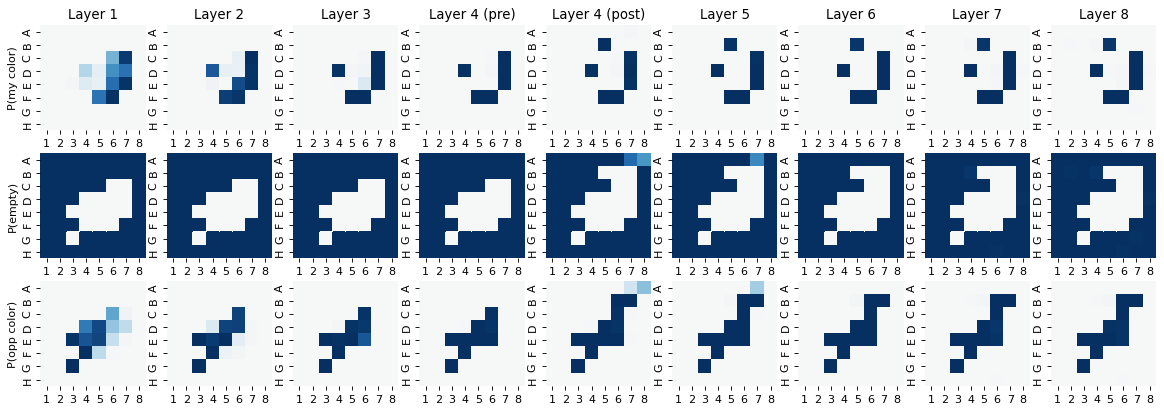

In [39]:
nrows, ncols = 3, len(data)
plot_scale = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * plot_scale, nrows * plot_scale), dpi=80, facecolor='w', edgecolor='k')

i_layer = intervene_layers[0]
true_pre_state = np.array(pre_board.get_state())
true_post_state = np.array(post_intv_board.get_state())

for i in range(len(data)):
    for j in range(3):
        board = data[i][:, j].copy()
        # if i < i_layer:
        #     board[true_pre_state != j] *= -1
        # else:
        #     board[true_post_state != j] *= -1

        sns.heatmap(board.reshape(8, 8), 
                    ax=axs[j][i], 
                    yticklabels=list("ABCDEFGH"), 
                    xticklabels=list(range(1,9)), 
                    square=True, 
                    center=0, vmax=1, vmin=-1,
                    cbar=False,
                    cmap="RdBu")

# setting titles
xticks = [str(x) for x in range(1, 9)]
xticks.insert(i_layer, f"{i_layer} (post)")
xticks.insert(i_layer, f"{i_layer} (pre)")
xticks.remove(str(i_layer))

# setting y axis labels
for i, name in enumerate(xticks):
    ax = axs[0, i]
    ax.set_title(f"Layer {name}")

axs[0, 0].set_ylabel("P(my color)")
axs[1, 0].set_ylabel("P(empty)")
axs[2, 0].set_ylabel("P(opp color)")

print(xticks)
     

### intervening on turn

In [40]:
all_layers = range(1, 9)
models, device = load_model_layers("bias/TLcontrol", all_layers)
board_probes = load_linear_probes("bias/probes/state_control", all_layers)
turn_probes = load_linear_probes("bias/probes/turn_control", all_layers, probe_class=2, num_task=1)
# models, device = load_model_layers("playertype/playertype_e40", all_layers)
# board_probes = load_linear_probes("playertype/probes/state", all_layers)
# player_probes = load_linear_probes("playertype/probes/player", all_layers, probe_class=4, num_task=1)

In [41]:
othello = Othello(data_root="othello_synthetic", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)
# othello = Othello(data_root="othello_1player", n_games=1000, deduplicate=False, test_split=0)
# player_types, games = zip(*othello)
# train_dataset = CharDataset(games)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 5.104 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


In [170]:
completion = othello[3][:41]
# pt, completion = othello[0]
# print("player:", pt)
# completion = completion[:10]

pre_board = OthelloBoardState()
pre_board.update(completion)
print("next color:", pre_board.get_next_hand_color())
pre_board.__print__()
print([permit_reverse(x) for x in pre_board.get_valid_moves()])

next color: 0
--------------------
['f5', 'd6', 'c6', 'f4', 'e6', 'c7', 'd7', 'f6', 'e3', 'e7', 'g3', 'd3', 'g5', 'f3', 'd8', 'h3', 'd2', 'c8', 'b6', 'd1', 'f2', 'f7', 'h4', 'h2', 'e8', 'a6', 'b7', 'h6', 'b5', 'c5', 'c1', 'g2', 'b4', 'c4', 'g7', 'e2', 'e1', 'a4', 'h1', 'g8', 'g6']
a       O   O    
b       O O X X  
c X     O O O O O
d X X O O O X X X
e X X X X X X X X
f   X X O X X X  
g   X X   O X X O
h X X X X   O    
  1 2 3 4 5 6 7 8
--------------------
['a5', 'a7', 'a8', 'b8', 'f1', 'f8', 'g1', 'g4', 'h7', 'h8']


In [171]:
flipped_turn_board = OthelloBoardState()
flipped_turn_board.update(completion)
flipped_turn_board.next_hand_color *= -1
print("next color:", flipped_turn_board.get_next_hand_color())
flipped_turn_board.__print__()
print([permit_reverse(x) for x in flipped_turn_board.get_valid_moves()])

next color: 1
--------------------
['f5', 'd6', 'c6', 'f4', 'e6', 'c7', 'd7', 'f6', 'e3', 'e7', 'g3', 'd3', 'g5', 'f3', 'd8', 'h3', 'd2', 'c8', 'b6', 'd1', 'f2', 'f7', 'h4', 'h2', 'e8', 'a6', 'b7', 'h6', 'b5', 'c5', 'c1', 'g2', 'b4', 'c4', 'g7', 'e2', 'e1', 'a4', 'h1', 'g8', 'g6']
a       O   O    
b       O O X X  
c X     O O O O O
d X X O O O X X X
e X X X X X X X X
f   X X O X X X  
g   X X   O X X O
h X X X X   O    
  1 2 3 4 5 6 7 8
--------------------
['a3', 'a5', 'b3', 'b8', 'c2', 'c3', 'g4', 'h5']


In [172]:
def get_probe_goal_state(ob):
    goal_state = [
        [5, -10, -2], # my color
        [-5, 10, -5], # empty
        [-2, -10, 5], # opp color
    ]
    desired_probe_state = np.zeros((64, 3))

    state = np.array(ob.get_state())
    desired_probe_state[state == 0] = goal_state[0]
    desired_probe_state[state == 1] = goal_state[1]
    desired_probe_state[state == 2] = goal_state[2]
    
    return desired_probe_state

In [182]:
i_layers = [3]
scale = 6
desired_probe_state = get_probe_goal_state(flipped_turn_board)

partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)
pre_intv_pred, _ = models[all_layers.stop-1](partial_game[None, :])  # [B, T, F=512]
pre_intv_pred = pre_intv_pred[0, -1, :].detach().cpu().numpy()

# tracking probes across the intervention
saved_turn_probe_logits = []
saved_board_probe_logits = []

for i, current_layer in enumerate(all_layers):
    p = turn_probes[current_layer]

    if i == 0:
        whole_mid_act = models[all_layers.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
    # after starting layer, use forward_2nd_stage to get to next layer
    else:
        whole_mid_act = models[all_layers.start].forward_2nd_stage(whole_mid_act, current_layer-1, current_layer)[0]  # [1, T, F=512]

    # cut out most recent features and check probe prediction
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)
    saved_turn_probe_logits.append(pre_intv_logits)
    saved_board_probe_logits.append(board_probes[current_layer](mid_act[None, :])[0].squeeze(0))

    if current_layer not in i_layers:
        continue

    # make actual intervention on mid activations
    new_mid_act = mid_act.clone()

    # linear steering intervention on turn
    m = p.proj.weight.data
    new_mid_act += m[1] * scale
    new_mid_act -= m[0] * scale

    # pinv = torch.pinverse(board_probes[current_layer].proj.weight.data)  # [512, 192]
    # desired_probe_tensor = torch.from_numpy(desired_probe_state).to(pinv.dtype).to(device)
    # new_mid_act = torch.matmul(pinv, desired_probe_tensor.reshape(192))

    # linear steering intervention on player
    # m = p.proj.weight.data
    # new_mid_act += m[3] * scale
    # new_mid_act -= m[0] * scale
    

    post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0) 
    saved_turn_probe_logits.append(post_intv_logits)
    saved_board_probe_logits.append(board_probes[current_layer](new_mid_act[None, :])[0].squeeze(0))

    # swap in 
    whole_mid_act[0, -1] = new_mid_act

post_intv_pred, _ = models[all_layers.start].predict(whole_mid_act)
post_intv_pred = post_intv_pred[0, -1, :].detach().cpu().numpy()

saved_turn_probe_logits = np.array([x.detach().cpu().numpy() for x in saved_turn_probe_logits])
saved_board_probe_logits = np.array([x.softmax(dim=-1).detach().cpu().numpy() for x in saved_board_probe_logits])

In [183]:
for l in saved_turn_probe_logits:
    print(l)

[[ 2.7633789 -3.093148 ]]
[[ 2.6786342 -2.8940673]]
[[ 2.980814  -3.2039125]]
[[-13.448289  12.937134]]
[[-9.325471  8.96652 ]]
[[-6.154212   5.7618527]]
[[-4.6809497  3.9832785]]
[[-4.8377786  4.1531873]]
[[-3.519786  2.857544]]


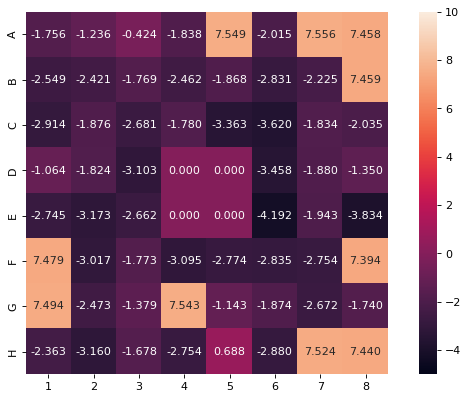

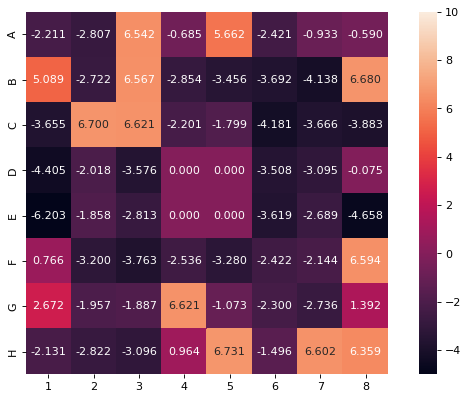

In [184]:
fig = draw_heatmap_from_tokens(pre_intv_pred, vmax=10, vmin=-5)
fig = draw_heatmap_from_tokens(post_intv_pred, vmax=10, vmin=-5)

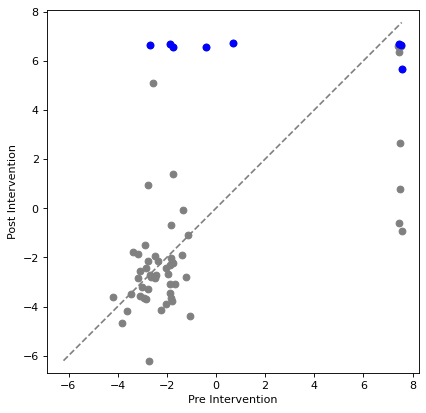

In [185]:
fig, ax = plt.subplots(1, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

x, y = pre_intv_pred[1:], post_intv_pred[1:]

# plotting illegal moves in grey
ax.scatter(x, y, color='grey', zorder=1)
# plotting legal moves as blue
valid_tokens = [train_dataset.stoi[x] - 1 for x in flipped_turn_board.get_valid_moves()]
ax.scatter(x[valid_tokens], y[valid_tokens], color='blue', zorder=2)

# plotting x=y for context
axis_min = min(min(x), min(y))
axis_max = max(max(x), max(y))
ax.plot([axis_min, axis_max], [axis_min, axis_max], color='grey', linestyle='dashed', zorder=0)

# axis, labels
ax.set_xlabel("Pre Intervention")
ax.set_ylabel("Post Intervention")
ax.axis('equal')

plt.show()

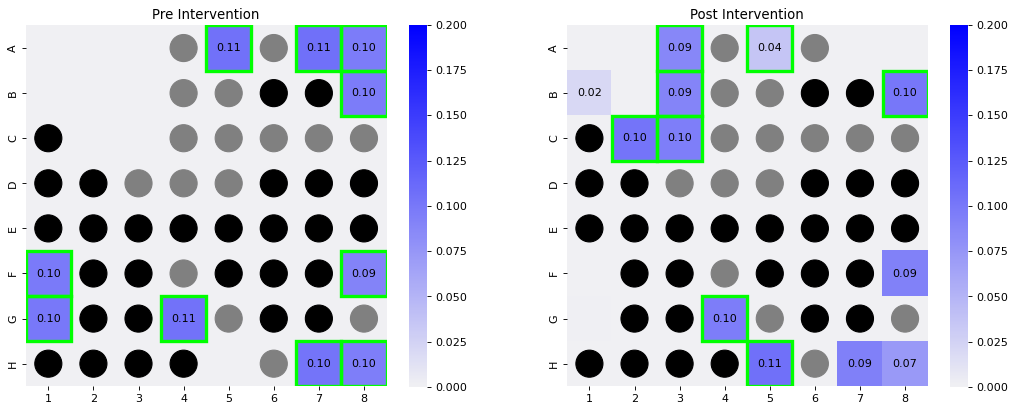

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=80)
draw_board_state_with_pred(axs[0], pre_board, format_pred(pre_intv_pred))
draw_board_state_with_pred(axs[1], flipped_turn_board, format_pred(post_intv_pred))

axs[0].set_title("Pre Intervention")
axs[1].set_title("Post Intervention")

plt.show()

In [179]:
def chart_board_probes_over_intervention(data, i_layers):
    nrows, ncols = 3, len(data)
    plot_scale = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * plot_scale, nrows * plot_scale), dpi=80, facecolor='w', edgecolor='k')

    for i in range(len(data)):
        for j in range(3):
            board = data[i][:, j].copy()

            sns.heatmap(board.reshape(8, 8), 
                        ax=axs[j][i], 
                        yticklabels=list("ABCDEFGH"), 
                        xticklabels=list(range(1,9)), 
                        square=True, 
                        vmax=1, vmin=0,
                        cbar=False,
                        cmap="Blues")

    # setting titles
    xticks = []
    for i in all_layers:
        if i in i_layers:
            xticks.append(f"Layer {i} (pre)")
            xticks.append(f"Layer {i} (post)")
        else:
            xticks.append(f"Layer {i}")

    # setting y axis labels
    for i, name in enumerate(xticks):
        ax = axs[0, i]
        ax.set_title(name, fontsize=14)

    axs[0, 0].set_ylabel("P(my color)", fontsize=14)
    axs[1, 0].set_ylabel("P(empty)", fontsize=14)
    axs[2, 0].set_ylabel("P(their color)", fontsize=14)

Text(0.5, 1.0, 'True State')

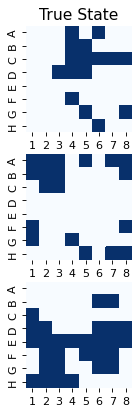

In [192]:
nrows, ncols = 3, 1
plot_scale = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * plot_scale, nrows * plot_scale), dpi=80, facecolor='w', edgecolor='k')

s = np.array(pre_board.get_state())
true_state = np.zeros((64, 3))
true_state[:, 0] = s == 0
true_state[:, 1] = s == 1
true_state[:, 2] = s == 2

for j in range(3):
    board = true_state[:, j].copy()

    sns.heatmap(board.reshape(8, 8), 
                ax=axs[j], 
                yticklabels=list("ABCDEFGH"), 
                xticklabels=list(range(1,9)), 
                square=True, 
                vmax=1, vmin=0,
                cbar=False,
                cmap="Blues")

axs[0].set_title("True State", fontsize=14)

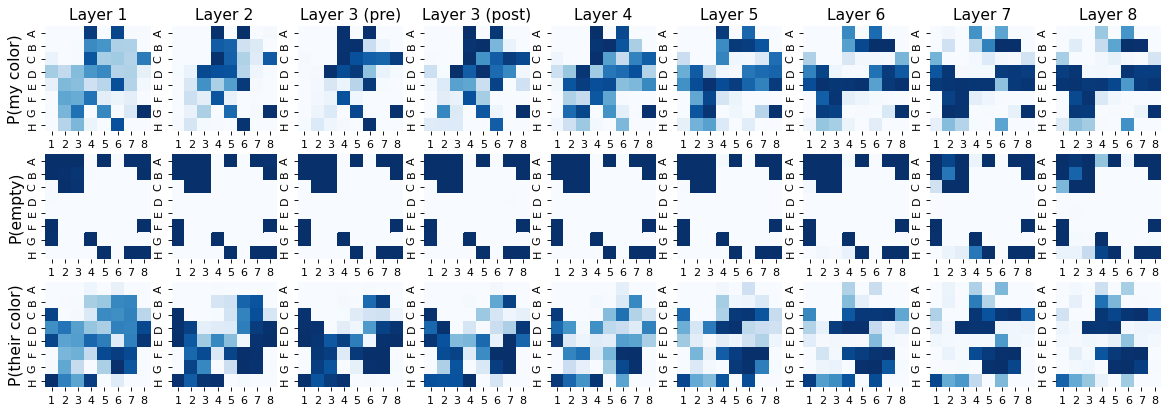

In [187]:
chart_board_probes_over_intervention(saved_board_probe_logits, i_layers)

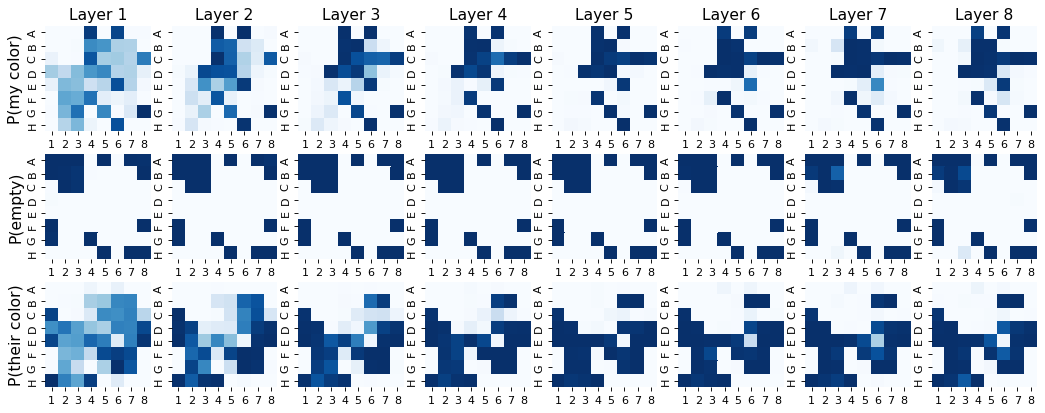

In [188]:
without_intv = [get_probe_logits(models, device, board_probes, l, completion, softmax=True) for l in all_layers]
chart_board_probes_over_intervention(without_intv, [])

### cumulative error, many interventions

In [77]:
from scipy.special import softmax
import pandas as pd
from typing import List
import itertools

In [78]:
all_layers = range(1, 9)
models, device = load_model_layers("bias/TLcontrol", all_layers)
board_probes = load_linear_probes("bias/probes/state_control", all_layers)
turn_probes = load_linear_probes("bias/probes/turn_control", all_layers, num_task=1, probe_class=2)

In [79]:
othello = Othello(data_root="othello_synthetic", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.968 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


In [80]:
BoardIntervention = namedtuple("BoardIntervention", ["pos", "start", "end"])

In [81]:
def intervene(models, device, probes, completion, i_layers, intvs=[], scale=1, desired_probe_state=None, desired_turn=1):
    all_layers = range(1, 9)

    partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)
    pre_intv_pred, _ = models[all_layers.stop-1](partial_game[None, :])  # [B, T, F=512]
    pre_intv_pred = pre_intv_pred[0, -1, :].detach().cpu().numpy()

    for i, current_layer in enumerate(all_layers):
        p = probes[current_layer]

        if i == 0:
            whole_mid_act = models[all_layers.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
        # after starting layer, use forward_2nd_stage to get to next layer
        else:
            whole_mid_act = models[all_layers.start].forward_2nd_stage(whole_mid_act, current_layer-1, current_layer)[0]  # [1, T, F=512]

        if current_layer not in i_layers:
            continue

        new_mid_act = whole_mid_act[0, -1].clone()

        # linear intervention (simple steering vector)
        # m = p.proj.weight.data.reshape((64, 3, -1))  # [64, 3, 512]
        # for bi in intvs:
        #     new_mid_act += m[permit(bi.pos), bi.end] * scale
        #     new_mid_act -= m[permit(bi.pos), bi.start] * scale

        # linear intervention (adding proj inverse of goal state)
        pinv = torch.pinverse(p.proj.weight.data)  # [512, 192]
        desired_probe_tensor = torch.from_numpy(desired_probe_state).to(pinv.dtype).to(device)
        new_mid_act = torch.matmul(pinv, desired_probe_tensor.reshape(192))

        # turn intervention
        # m = p.proj.weight.data
        # new_mid_act += m[desired_turn] * scale
        # new_mid_act -= m[1 - desired_turn] * scale

        # swap in 
        whole_mid_act[0, -1] = new_mid_act

    post_intv_pred, _ = models[all_layers.start].predict(whole_mid_act)
    post_intv_pred = post_intv_pred[0, -1, :].detach().cpu().numpy()

    return pre_intv_pred, post_intv_pred

#### simple steering vector interventions

In [17]:
def get_post_intv_board(completion, intvs):
    ob = OthelloBoardState()
    ob.update(completion)

    for bi in intvs:
        pos = permit(bi.pos)
        r, c = pos // 8, pos % 8
        new = bi.end
        if ob.get_next_hand_color() == 1:
            new = 2 - bi.end
        ob.state[r, c] = new - 1
    return ob

In [18]:
def get_all_possible_single_intvs(completion):
    ob = OthelloBoardState()
    ob.update(completion)

    possible_intvs = []
    for i, current in enumerate(ob.get_state()):
        current = int(current)
        if current == 1:
            continue
        possible_intvs.append(BoardIntervention(permit_reverse(i), current, 2 - current))

    return possible_intvs

In [19]:
saved_intv_results = []

In [20]:
# pairs of game_index and seq_len
seq_data = []
for i in range(20, 50):
    seq = othello[i]
    for j in range(1, len(seq)):
        seq_data.append((i, j))
print(len(seq_data))

1769


In [ ]:
bar = tqdm(seq_data)
for game_index, seq_len in bar:
    completion = othello[game_index][:seq_len]
    possible_intvs = get_all_possible_single_intvs(completion)

    for bi in possible_intvs:
        pre, post = intervene(models, device, board_probes, completion, [4], intvs=[bi], scale=4)

        post_ob = get_post_intv_board(completion, [bi])
        valid_tokens = [train_dataset.stoi[x] for x in post_ob.get_valid_moves()]
        valid_prob = softmax(post)[valid_tokens]
        error = 1 - np.sum(valid_prob)

        row = {
            "game_index": game_index,
            "seq_len": seq_len,
            "pos": permit(bi.pos),
            "start": bi.start,
            "end": bi.end,
            "error": error,
        }
        saved_intv_results.append(row)

        bar.set_description(f"{len(saved_intv_results)} intvs")

42478 intvs:   0%|          | 0/1769 [00:00<?, ?it/s]

102591 intvs: 100%|██████████| 1769/1769 [12:41<00:00,  2.32it/s]


In [ ]:
intv_df = pd.DataFrame(saved_intv_results)

<BarContainer object of 59 artists>

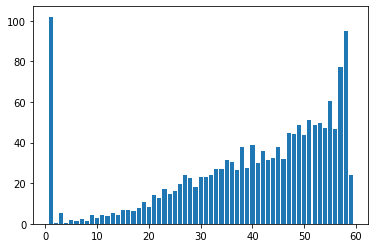

In [ ]:
time_split = []
vals = sorted(intv_df['seq_len'].unique())
for i in vals:
    f = intv_df[intv_df['seq_len'] == i]
    time_split.append(f['error'].sum())

plt.bar(vals, time_split)
    

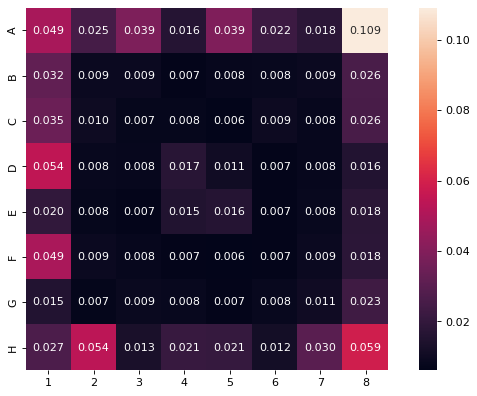

In [ ]:
pos_split = []
for i in range(64):
    f = intv_df[intv_df['pos'] == i]
    pos_split.append(f['error'].sum() / len(f))

fig = draw_board_heatmap(np.array(pos_split))

#### matrix intervention

In [98]:
def get_probe_goal_state(ob):
    goal_state = [
        [5, -10, -2], # my color
        [-5, 10, -5], # empty
        [-2, -10, 5], # opp color
    ]
    desired_probe_state = np.zeros((64, 3))

    state = np.array(ob.get_state())
    desired_probe_state[state == 1] = goal_state[1]
    if ob.get_next_hand_color():
        desired_probe_state[state == 2] = goal_state[0]
        desired_probe_state[state == 0] = goal_state[2]
    else:
        desired_probe_state[state == 0] = goal_state[0]
        desired_probe_state[state == 2] = goal_state[2]
    
    return desired_probe_state

In [130]:
saved_intv_results = []

In [131]:
MatrixIntvConfig = namedtuple("MatrixIntvConfig", ["start_game", "start_seq_len", "end_game", "end_seq_len", "layer"])
intv_configs: List[MatrixIntvConfig] = []

for g1, g2, s1, s2 in itertools.product(range(10), range(10), range(1, 60), range(1, 60)):
    intv_configs.append(MatrixIntvConfig(g1, s1, g2, s2, 4))

print(len(intv_configs))
print(intv_configs[:10])

348100
[MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=1, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=2, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=3, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=4, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=5, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=6, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=7, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=8, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=9, layer=4), MatrixIntvConfig(start_game=0, start_seq_len=1, end_game=0, end_seq_len=10, layer=4)]


In [132]:
bar = tqdm(intv_configs)
for intv_conf in bar:
    start_completion = othello[intv_conf.start_game][:intv_conf.start_seq_len]
    end_completion = othello[intv_conf.end_game][:intv_conf.end_seq_len]

    post_ob = OthelloBoardState()
    post_ob.update(end_completion)
    end_state = get_probe_goal_state(post_ob)

    pre, post = intervene(models, device, board_probes, start_completion, [intv_conf.layer], desired_probe_state=end_state)

    valid_tokens = [train_dataset.stoi[x] for x in post_ob.get_valid_moves()]
    valid_prob = softmax(post)[valid_tokens]
    error = 1 - np.sum(valid_prob)

    row = intv_conf._asdict()
    row["error"] = error
    saved_intv_results.append(row)

  0%|          | 6/348100 [00:00<1:43:06, 56.27it/s]

100%|██████████| 348100/348100 [1:51:11<00:00, 52.17it/s]


In [133]:
intv_df = pd.DataFrame(saved_intv_results)
print(intv_df)

        start_game  start_seq_len  end_game  end_seq_len  layer     error
0                0              1         0            1      4  0.144090
1                0              1         0            2      4  0.468470
2                0              1         0            3      4  0.171071
3                0              1         0            4      4  0.518475
4                0              1         0            5      4  0.375811
...            ...            ...       ...          ...    ...       ...
348095           9             59         9           55      4  0.535072
348096           9             59         9           56      4  0.000249
348097           9             59         9           57      4  0.199834
348098           9             59         9           58      4  0.000163
348099           9             59         9           59      4  0.019490

[348100 rows x 6 columns]


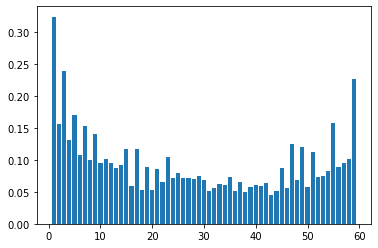

In [138]:
col = 'end_seq_len'

time_split = []
vals = sorted(intv_df[col].unique())
for i in vals:
    f = intv_df[intv_df[col] == i]
    avg_error = f['error'].sum() / len(f)
    time_split.append(avg_error)

plt.bar(vals, time_split)
# plt.xlabel("Layer")
# plt.ylabel("Avg Error")
# plt.title("Matrix Intervention")
# baseline_error = 0.7581
# plt.axhline(y=baseline_error, color='red', linestyle='--', label='Baseline Error')
# plt.text(0.5, baseline_error - 0.05, f'Baseline Error: {baseline_error:.4f}', color='red')
plt.show()

In [151]:
grid = np.zeros((59, 59))
for i in range(59):
    for j in range(59):
        f = intv_df
        # f = f[f['layer'] == 4]
        f = f[(f['start_seq_len'] == i+1) & (f['end_seq_len'] == j+1)]
        if not len(f):
            continue
        avg_error = f['error'].sum() / len(f)
        grid[(i, j)] = avg_error

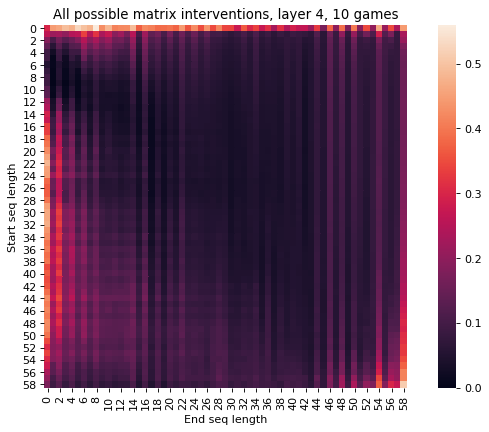

In [153]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(grid, ax=ax, square=True, vmin=0)
ax.set_xlabel("End seq length")
ax.set_ylabel("Start seq length")
ax.set_title("All possible matrix interventions, layer 4, 10 games")
plt.show()

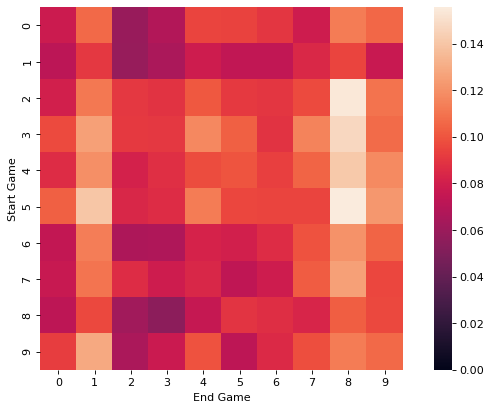

In [149]:
grid = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        f = intv_df
        f = f[(f['start_game'] == i) & (f['end_game'] == j)]
        avg_error = f['error'].sum() / len(f)
        grid[(i, j)] = avg_error

fig, ax = plt.subplots(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(grid, ax=ax, square=True, vmin=0)
ax.set_xlabel("End Game")
ax.set_ylabel("Start Game")
plt.show()

#### turn intervention

In [27]:
saved_intv_results = []

In [26]:
TurnIntvConfig = namedtuple("TurnIntvConfig", ["game", "seq_len", "original_turn", "layer", "scale"])
intv_configs: List[TurnIntvConfig] = []

for game, s_len, layer, scale in itertools.product(range(20), range(1, 60), range(1, 9), [1, 2, 4, 8, 16]):
    ob = OthelloBoardState()
    ob.update(othello[game][:s_len])
    intv_configs.append(TurnIntvConfig(game, s_len, ob.get_next_hand_color(), layer, scale))

print(len(intv_configs))

0it [00:00, ?it/s]

47200it [00:28, 1684.59it/s]

47200


In [29]:
bar = tqdm(intv_configs)
for intv_conf in bar:
    completion = othello[intv_conf.game][:intv_conf.seq_len]

    flipped_ob = OthelloBoardState()
    flipped_ob.update(completion)
    original_turn = flipped_ob.get_next_hand_color()
    flipped_ob.next_hand_color *= -1

    pre, post = intervene(models, device, turn_probes, completion, [intv_conf.layer], desired_turn=1 - original_turn, scale=intv_conf.scale)

    valid_tokens = [train_dataset.stoi[x] for x in flipped_ob.get_valid_moves()]
    valid_prob = softmax(post)[valid_tokens]
    error = 1 - np.sum(valid_prob)

    row = intv_conf._asdict()
    row["error"] = error
    saved_intv_results.append(row)

100%|██████████| 47200/47200 [10:28<00:00, 75.07it/s]


In [30]:
intv_df = pd.DataFrame(saved_intv_results)
print(intv_df)

       game  seq_len  original_turn  layer  scale     error
0         0        1              0      1      1  0.999997
1         0        1              0      1      2  0.999997
2         0        1              0      1      4  0.999997
3         0        1              0      1      8  0.999997
4         0        1              0      1     16  0.999996
...     ...      ...            ...    ...    ...       ...
47195    19       59              0      8      1  0.000006
47196    19       59              0      8      2  0.000007
47197    19       59              0      8      4  0.000008
47198    19       59              0      8      8  0.000022
47199    19       59              0      8     16  0.000349

[47200 rows x 6 columns]


Text(0.5, 1.0, 'Turn Intervention')

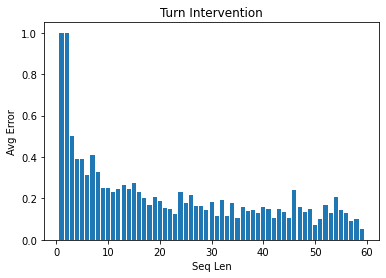

In [42]:
col = 'seq_len'

time_split = []
vals = sorted(intv_df[col].unique())
for i in vals:
    f = intv_df[intv_df[col] == i]
    f = f[f['layer'] == 1]
    f = f[f['scale'] == 2]
    avg_error = f['error'].sum() / len(f)
    time_split.append(avg_error)

plt.bar(vals, time_split)
plt.xlabel("Seq Len")
plt.ylabel("Avg Error")
plt.title("Turn Intervention")

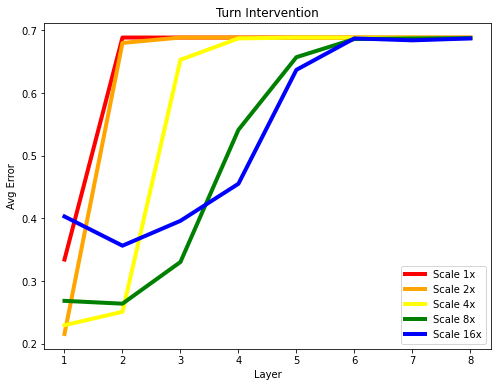

In [49]:
scale_data = {i: [] for i in [1, 2, 4, 8, 16]}

for s in scale_data:
    for layer in all_layers:
        f = intv_df
        f = f[f['scale'] == s]
        f = f[f['layer'] == layer]
        avg_error = f['error'].sum() / len(f)
        scale_data[s].append(avg_error)

colors = ["red", "orange", "yellow", "green", "blue"]
plt.figure(figsize=(8, 6))
for (s, data), color in zip(scale_data.items(), colors):
    plt.plot(all_layers, data, color=color, label=f"Scale {s}x", lw=4)

plt.title("Turn Intervention")
plt.xlabel("Layer")
plt.ylabel("Avg Error")
plt.legend()
plt.show()